# 6. Deep Learning for Text and Sequences

## Sequence Processing with convnets

Convnets have a particularly performance in computer vision problems due to their ability to operate convolutionally, extracting features from local input patches and allowing for representation modularity and data efficiency. These same properties allow them to be useful at sequence processing.

1D convnets can be competitive with RNNs on certain sequence processing problems, usually at a considerably cheaper computational cost. Recently, 1D convnets, typically used with dilated kernals have been used with great success for audio generation and machine translation.

In [10]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import imdb

from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import (Embedding, Dense, SimpleRNN, LSTM, MaxPooling1D, Conv1D, GlobalMaxPooling1D)

### Understanding 1D convolution for sequence data

Recall that in 2D convolutions, the layers extract 2D patches (areas) from image tensors. Similarly, a 1D convolution extracts 1D subsequences from a sequence.

<img src="img65.png" width="700">

These 1D convolution layers can recognise local patterns in a sequence. Because the <u>same input transformation is performed on every patch</u>, a pattern learned in one position can later be recognised at a different position (translation invariance). A character-level 1D convnet is thus able to learn about morphology ("-ly", "-ing", "un-", "dis-", "-ed" etc.)

### Implementing a 1D convnet

In Keras we can use the `Conv1D` layer, which takes in an input 3D tensors with shape `(samples, timesteps, features)` and outputs similarly shaped 3D tensors.

The network consist of a stack of `Conv1D` and `MaxPooling1D` layers, similar to their 2D counterparts. You can affort to use a larger convolution windows with 1D convnets. A 3X3 layer has 9 features in a 2D convnet but a 3-dim layer in a 1D convnet has only 3 features.

In [2]:
# Ingestion
###########
VOCABULARY_SIZE = 10000
DOCUMENT_MAX_LENGTH = 500
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=VOCABULARY_SIZE)
x_train = sequence.pad_sequences(train_data, maxlen=DOCUMENT_MAX_LENGTH)
x_test = sequence.pad_sequences(test_data, maxlen=DOCUMENT_MAX_LENGTH)

### v1: Simple 1D Convnet

In [8]:
# Instantiate Model
###################
# clear_session()
# model1 = Sequential()
# model1.add(Embedding(VOCABULARY_SIZE, 128, input_length=DOCUMENT_MAX_LENGTH))
# model1.add(Conv1D(32, 7, activation='relu'))
# model1.add(MaxPooling1D(5))
# model1.add(Conv1D(32, 7, activation='relu'))
# model1.add(GlobalMaxPooling1D())
# model1.add(Dense(1))

# Compile
#########
# model1.compile(optimizer=RMSprop(learning_rate=1e-4), 
#                loss='binary_crossentropy',
#                metrics=['acc'])
# print(model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
______________________________________________

In [9]:
# history1 = model1.fit(x_train, train_labels,
#                       epochs=10, 
#                       validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 63s 101ms/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 2/10
625/625 [==============================] - 77s 124ms/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 3/10
625/625 [==============================] - 76s 122ms/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 4/10
625/625 [==============================] - 70s 112ms/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 5/10
625/625 [==============================] - 169s 271ms/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 6/10
625/625 [==============================] - 57s 91ms/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 7/10
625/625 [==============================] - 61s 97ms/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 8/10
625/625 [==============================] - 96

In [14]:
# Save Model & Training Results
###############################
model1.save('model64_1D_CNN.h5')
pd.DataFrame(history1.history).to_csv('model64_1D_CNN_history.csv', index=False)

,loss,acc,val_loss,val_acc,epoch
5,7.736389,0.49845,7.616838,0.5062,6
6,7.736383,0.49845,7.616838,0.5062,7
7,7.736392,0.49845,7.616838,0.5062,8
8,7.736390,0.49845,7.616838,0.5062,9
9,7.736394,0.49845,7.616838,0.5062,10


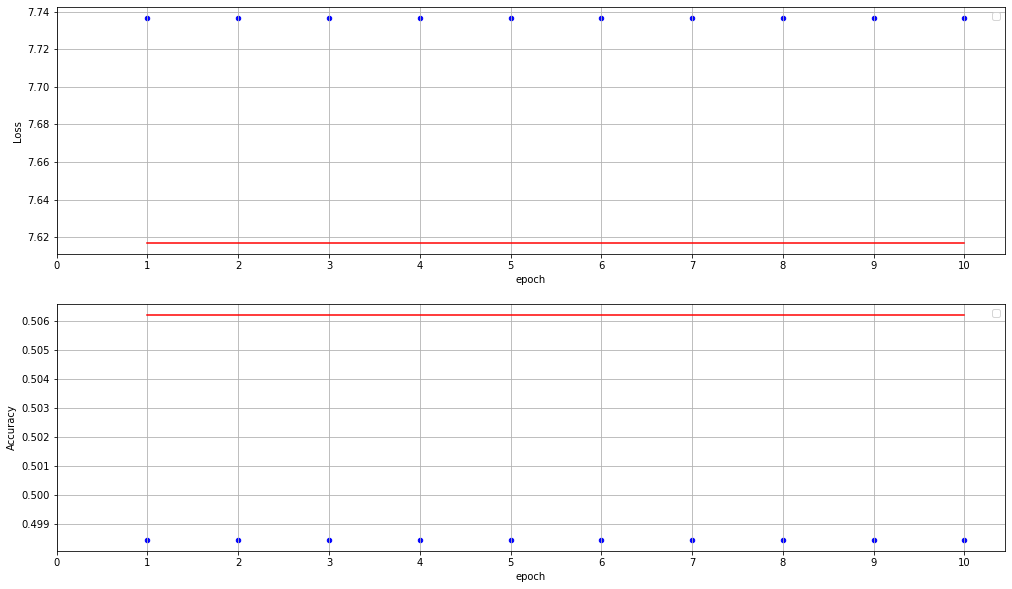

In [13]:
metrics_df = pd.DataFrame(history1.history)
metrics_df['epoch'] = metrics_df.index+1
display(metrics_df.tail())

fig = plt.figure(figsize=(17,10))
ax1, ax2 = fig.add_subplot(2,1,1), fig.add_subplot(2,1,2)
metrics_df.plot(kind='scatter', x='epoch', y='loss', ax=ax1, label='train', color='blue')
metrics_df.plot(kind='line', x='epoch', y='val_loss', ax=ax1, label='validation', color='red',)
ax1.set_ylabel("Loss")
ax1.grid('GAINSBORO')
ax1.legend([])
ax1.set_xticks(range(0,11))

metrics_df.plot(kind='scatter', x='epoch', y='acc', ax=ax2, label='train', color='blue')
metrics_df.plot(kind='line', x='epoch', y='val_acc', ax=ax2, label='validation', color='red',)
ax2.set_ylabel("Accuracy")
ax2.grid('GAINSBORO')
ax2.set_xticks(range(0,11))
ax2.legend([])
plt.show()

### Combining CNNs and RNNs to process long sequences

Because 1D convnets process input batches independently, they aren't sensitive to the order of the timesteps, unlike RNNs. To recognise longer-term patterns, you may stack many convolutional & pooling layers, resulting in upper layers that will see long chungs of the original inputs. We can see this when we use 1D convnets on the **temperature-forecasting** problem.

In [ ]:
# Instantiate Model
###################
clear_session()
model2 = Sequential()
model2.add(Embedding(VOCABULARY_SIZE, 128, input_length=DOCUMENT_MAX_LENGTH))
model2.add(Conv1D(32, 7, activation='relu'))
model2.add(MaxPooling1D(5))
model2.add(Conv1D(32, 7, activation='relu'))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(1))

Compile
########
model2.compile(optimizer=RMSprop(learning_rate=1e-4), 
               loss='binary_crossentropy',
               metrics=['acc'])
print(model2.summary())